In [ ]:
## 1. Transform data to record format
## First dataset from http://www.robots.ox.ac.uk/~vgg/data/scenetext/
## This method failed, because 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import scipy.io as sio
import gzip
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
import tensorflow as tf
import skimage.io as skio
#tf.InteractiveSession()
from PIL import Image
import re
import os
slim = tf.contrib.slim
tf.__version__
#from image_processing2 import *
from processing import txt_preprocessing
import tf_extended as tfe
from processing import tf_image
from nets import txtbox_300
import tf_utils
from nets import custom_layers
import load_batch

In [2]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

text_shape (300, 300)
file_path: ../data/sythtext/*.tfrecord
0.592157 -0.337311
(300, 300, 3)
0.594608 -0.519975
[[31, 98, 216, 37, 129, 181, 243, -11, 3], [266, 289, 286, 6, 3, -1, -3, 242, 289], [71, 135, 263, 119, 192, 288, 298, 24, 31], [281, 313, 315, 127, 113, 149, 84, 292, 305]]


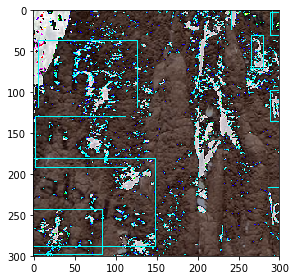

[[218, 237, 93, 101, 125, 158, 181, 179, 96, 140, 164, 194, 11, 9, 21, 32, 73, 80, 85], [58, 48, 195, 211, 209, 213, 207, 229, 46, 44, 41, 40, 82, 101, 78, 78, 182, 209, 221], [236, 254, 112, 120, 143, 176, 203, 202, 135, 170, 215, 220, 20, 16, 32, 44, 90, 94, 100], [80, 70, 204, 232, 223, 232, 224, 242, 116, 107, 128, 91, 92, 108, 103, 116, 210, 218, 233]]


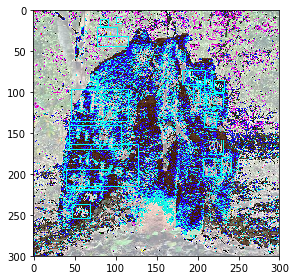

0.592157 -0.381278
(300, 300, 3)
0.592769 -0.528344
[[276, 253, 22, 16, 27, 22, 279, 259, 251, 258, 10, 28], [164, 16, 39, 231, 240, 250, 148, 55, 237, 250, 38, 39], [298, 300, 30, 65, 78, 94, 297, 280, 281, 283, 22, 44], [179, 62, 77, 263, 274, 298, 164, 110, 248, 261, 81, 85]]


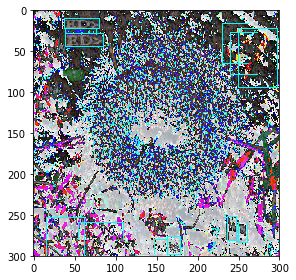

[[276, 253, 22, 16, 27, 22, 279, 259, 251, 258, 10, 28], [164, 16, 39, 231, 240, 250, 148, 55, 237, 250, 38, 39], [298, 300, 30, 65, 78, 94, 297, 280, 281, 283, 22, 44], [179, 62, 77, 263, 274, 298, 164, 110, 248, 261, 81, 85]]


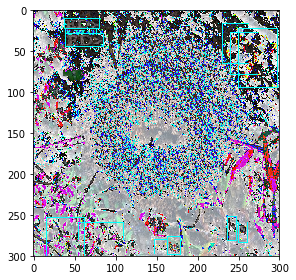

0.592157 -0.458824
(300, 300, 3)
0.60311 -0.499216
[[100, 34, 73, 101, 138], [-12, 116, 137, 156, 184], [197, 66, 101, 142, 190], [105, 218, 225, 248, 296]]


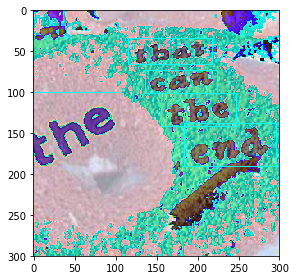

[[164, 144, 123, 192, 160, 200, 209, 190, 81, 48, 67, 81, 100], [18, 53, 79, 38, 70, 61, 76, 119, 126, 182, 191, 200, 212], [201, 175, 154, 216, 195, 229, 242, 213, 128, 64, 81, 101, 125], [56, 77, 105, 71, 103, 97, 113, 143, 177, 227, 230, 240, 261]]


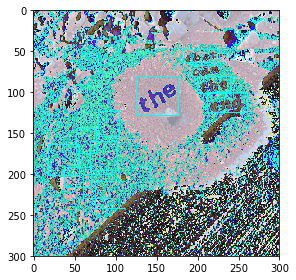

0.592157 -0.482353
(300, 300, 3)
0.582217 -0.530198
[[222, 184, 222, 182, 149], [8, 115, -12, 78, 188], [299, 258, 268, 230, 189], [144, 243, 70, 161, 267]]


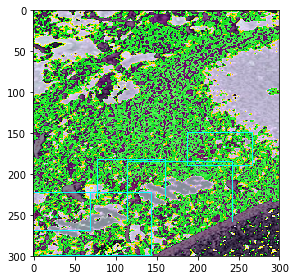

[[212, 181, 54, 92, 212, 179, 152, 65, 80], [8, 55, 183, 127, 0, 39, 86, 188, 196], [275, 242, 67, 117, 249, 218, 185, 79, 98], [67, 110, 221, 152, 36, 75, 120, 220, 238]]


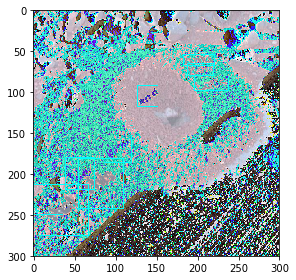

0.513428 -0.482353
(300, 300, 3)
0.568524 -0.539904
[[50, 23, 30, 125, 111, 153, 135, 184, 162, 219, 192, 259, 227], [184, 151, 176, 36, 129, 33, 132, 29, 135, 25, 138, 20, 142], [72, 46, 51, 145, 138, 176, 166, 210, 199, 249, 235, 294, 277], [214, 166, 193, 75, 264, 75, 272, 75, 285, 75, 296, 75, 311]]


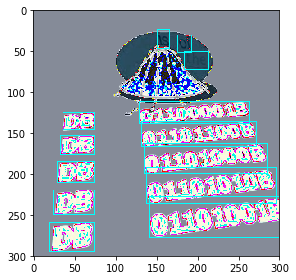

[[83, 6, 6, 19, 63, 68, 141, 129, 162, 148, 185, 169, 212, 192, 243, 218], [172, 87, 225, 87, 144, 166, 44, 125, 41, 127, 38, 130, 34, 133, 30, 136], [100, 15, 15, 32, 80, 84, 156, 150, 179, 172, 205, 197, 235, 225, 270, 257], [198, 216, 260, 236, 157, 181, 78, 241, 78, 249, 78, 260, 78, 270, 78, 282]]


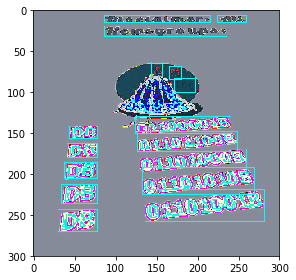

In [14]:
#out_shape = [700,700]
with tf.Graph().as_default(): 
    # build a net
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])

    
    image_train, tlabels, tbboxes,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],is_training=True)
    image_test, elabels, ebboxes, bbox_img,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],is_training=False)
    batch_image = slim.batch_norm(image_train)
    #scala_image = tf.cast(image_train, tf.uint8)
    
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(5):
                image_, batch_image_,image_test_,bbox_,test_box= sess.run([image_train,batch_image,image_test,tbboxes,ebboxes])
                #image_ = image_*255
                print image_.max(),image_.min()
                print image_.shape
                print image_test_.max(), image_test_.min()
                image_ = image_ * 255.
                image_ = image_.astype(np.uint8)
                visualize_bbox(image_, bbox_)
                image_test_ = image_test_ * 255.
                image_test_ = image_test_.astype(np.uint8)
                visualize_bbox(image_test_, test_box)
                
                

[[218, 223, 259, 264], [11, 184, 81, 221], [256, 260, 278, 282], [166, 288, 213, 281]]


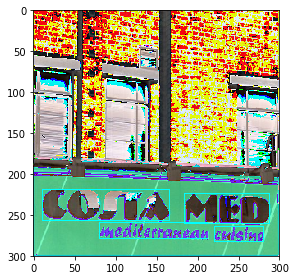

In [9]:
image_test_ = image_test_ * 255.0
image_test_ = image_test_.astype(np.uint8)
visualize_bbox(image_test_, test_box)


In [ ]:
image_ = image_ *255.0
image_ = image_.astype(np.uint8)
visualize_bbox(image_, bbox_)

In [ ]:
image_ = image_.astype(np.uint8)
#skio.imshow(np.uint8(image_bbox_p[0,:,:,:])*255)
skio.imshow(image_)

In [ ]:
for i in range(6):
    pmask = gscores_[i] > 0.5
    print np.sum(pmask)
bbox_

In [ ]:
for i in range(6):
    print np.where(gscores_[i] >0.1)
gscores_[0].shape

In [ ]:
loss

In [ ]:
pos_loss = 0
neg_loss = 0
for i in range(6):
    p_mask = np.int32(np.greater(b_gscores_[i] , 0.5))
    print np.sum(p_mask)
    n_mask = np.int32(np.less(b_gscores_[i] , 0.5))
    pos_loss += np.mean(pow((p_mask * (logits_[i][:,:,:,:,:,1] - p_mask)),2))
    neg_loss += np.mean(pow((n_mask * (logits_[i][:,:,:,:,:,0] - n_mask)),2))
print pos_loss,neg_loss